In [56]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score


In [57]:
# Pastikan jalur relatif sesuai struktur folder Anda
train_path = "../Data/proteinas_train.csv"
test_path = "../Data/proteinas_test.csv"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [58]:
# Ukuran dan kolom
print("Train Shape:", train.shape)
print("Test Shape:", test.shape)
print("Train Columns:", train.columns.tolist())

# Tampilkan beberapa sampel
display(train.head())


Train Shape: (16000, 10)
Test Shape: (4000, 10)
Train Columns: ['ID_Proteína', 'Sequência', 'Massa_Molecular', 'Ponto_Isoelétrico', 'Hidrofobicidade', 'Carga_Total', 'Proporção_Polar', 'Proporção_Apolar', 'Comprimento_Sequência', 'Classe']


,ID_Proteína,Sequência,Massa_Molecular,Ponto_Isoelétrico,Hidrofobicidade,Carga_Total,Proporção_Polar,Proporção_Apolar,Comprimento_Sequência,Classe
0,TRAIN_P00001,GNMRFVLHDEETHWGTLRTTLNCVPSDIYTISGEDSLFWGMAHPFC...,20362.9468,4.866123,0.149425,-3,0.241379,0.408046,174,Estrutural
1,TRAIN_P00002,LFKMQCSFYLLYLAKEAASYQVSMNMLCYEWYNYVYQVTVILRLSR...,9328.7909,6.298636,0.217105,0,0.210526,0.513158,76,Estrutural
2,TRAIN_P00003,PAHLWPYWRFYVWIVFYGYHNPNYHFGMKEVKERPDCKNCTVAVLF...,17616.3852,8.458977,0.192568,8,0.141892,0.466216,148,Estrutural
3,TRAIN_P00004,GEAFSRPHCFACAATKKGFPWARMCCTTSMAMDGVQSKMHKSKHRF...,35244.2968,8.448340,0.160473,21,0.189189,0.408784,296,Estrutural
4,TRAIN_P00005,HYVFQGLMLHCGGYMITACGFGVIFPEQMTREGLIMHTARAHHFLI...,34557.9931,7.696306,0.140411,18,0.202055,0.380137,292,Receptora


In [59]:
train.info()
test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID_Proteína            16000 non-null  object 
 1   Sequência              16000 non-null  object 
 2   Massa_Molecular        16000 non-null  float64
 3   Ponto_Isoelétrico      16000 non-null  float64
 4   Hidrofobicidade        16000 non-null  float64
 5   Carga_Total            16000 non-null  int64  
 6   Proporção_Polar        16000 non-null  float64
 7   Proporção_Apolar       16000 non-null  float64
 8   Comprimento_Sequência  16000 non-null  int64  
 9   Classe                 16000 non-null  object 
dtypes: float64(5), int64(2), object(3)
memory usage: 1.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  --

In [60]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Massa_Molecular,16000.0,20708.209250,8678.439780,5463.212900,13165.853975,20597.677000,28193.961625,37588.751700
Ponto_Isoelétrico,16000.0,7.274537,1.448253,4.050028,6.048970,7.196834,8.586190,11.711987
Hidrofobicidade,16000.0,0.149983,0.027485,0.014563,0.132911,0.150000,0.167364,0.284314
Carga_Total,16000.0,8.729938,7.537891,-20.000000,3.000000,8.000000,13.000000,47.000000
Proporção_Polar,16000.0,0.200260,0.033875,0.049180,0.178899,0.200000,0.221239,0.380282
Proporção_Apolar,16000.0,0.399930,0.042192,0.200000,0.373376,0.400000,0.426573,0.607843
Comprimento_Sequência,16000.0,174.033688,72.920304,50.000000,111.000000,173.000000,237.000000,300.000000


In [61]:
if 'target' in train.columns:
    train['target'].value_counts(normalize=True).plot(kind='bar', title='Distribusi Target')


In [62]:
missing_train = train.isnull().sum()
missing_pct = (missing_train / len(train)).sort_values(ascending=False)
missing_summary = pd.DataFrame({'Missing Count': missing_train, 'Missing %': missing_pct})
display(missing_summary[missing_summary['Missing Count'] > 0])


,Missing Count,Missing %


In [63]:
dup_count = train.duplicated().sum()
print(f"Jumlah baris duplikat: {dup_count} dari total {train.shape[0]} baris")


Jumlah baris duplikat: 0 dari total 16000 baris


In [64]:
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = train.select_dtypes(include=[np.number]).columns.tolist()
print("Fitur kategorikal:", categorical_cols)
print("Fitur numerik:", numerical_cols)


Fitur kategorikal: ['ID_Proteína', 'Sequência', 'Classe']
Fitur numerik: ['Massa_Molecular', 'Ponto_Isoelétrico', 'Hidrofobicidade', 'Carga_Total', 'Proporção_Polar', 'Proporção_Apolar', 'Comprimento_Sequência']


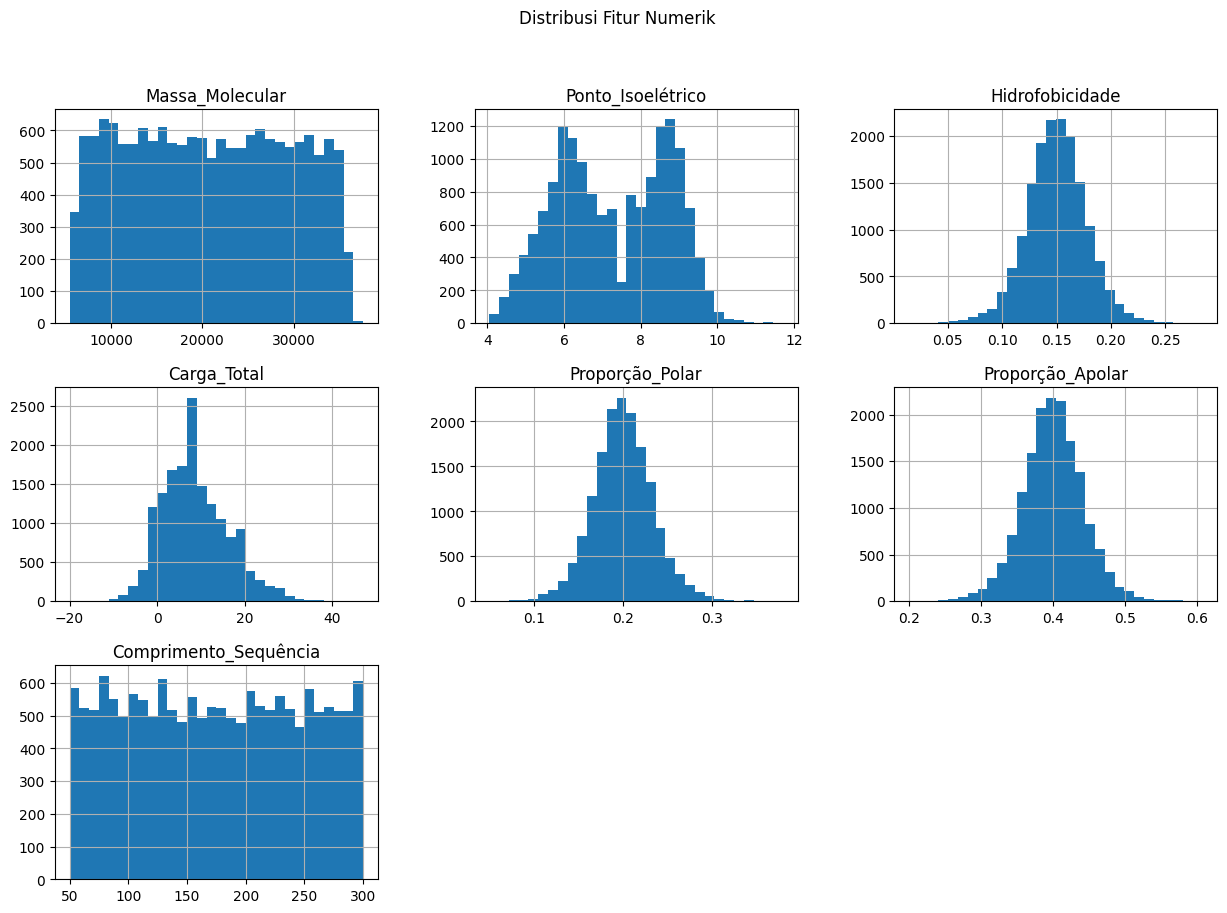

In [65]:
train[numerical_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle("Distribusi Fitur Numerik")
plt.show()


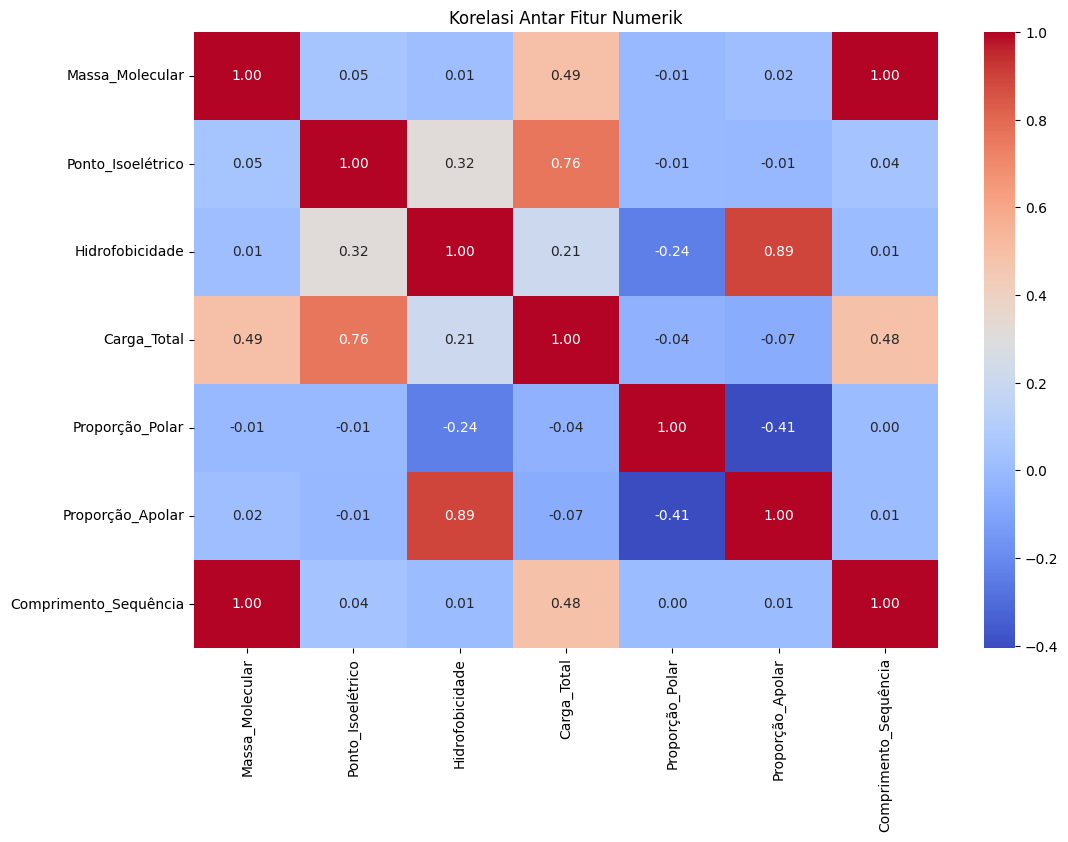

In [66]:
corr = train[numerical_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Korelasi Antar Fitur Numerik")
plt.show()


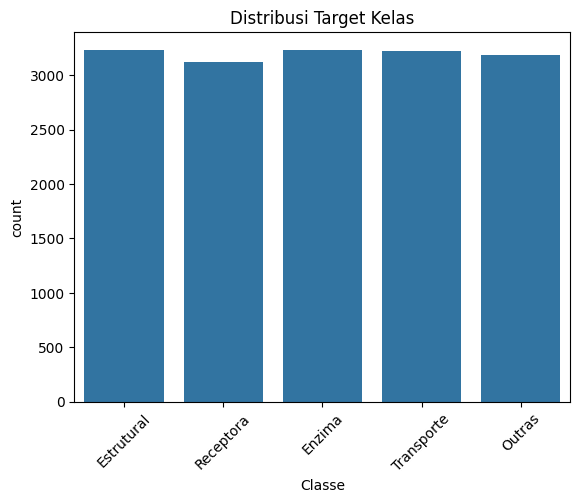

Classe
Enzima        0.202187
Estrutural    0.202000
Transporte    0.201563
Outras        0.198937
Receptora     0.195312
Name: proportion, dtype: float64


In [67]:
sns.countplot(data=train, x='Classe')
plt.title('Distribusi Target Kelas')
plt.xticks(rotation=45)
plt.show()

print(train['Classe'].value_counts(normalize=True))

In [68]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = train[['Massa_Molecular', 'Ponto_Isoelétrico', 'Hidrofobicidade', 'Carga_Total',
           'Proporção_Polar', 'Proporção_Apolar', 'Comprimento_Sequência']]

# Hitung VIF
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


                 Feature          VIF
0        Massa_Molecular  3574.541434
1      Ponto_Isoelétrico    79.100689
2        Hidrofobicidade   157.846524
3            Carga_Total    12.658143
4        Proporção_Polar    29.739606
5       Proporção_Apolar   275.557247
6  Comprimento_Sequência  3498.735748


In [69]:
from scipy.stats import f_oneway, kruskal

for col in ['Massa_Molecular', 'Ponto_Isoelétrico', 'Hidrofobicidade', 'Carga_Total',
            'Proporção_Polar', 'Proporção_Apolar', 'Comprimento_Sequência']:
    groups = [group[col].values for name, group in train.groupby('Classe')]
    stat, p = kruskal(*groups)
    print(f'{col}: p-value = {p}')


Massa_Molecular: p-value = 0.2225550355806119
Ponto_Isoelétrico: p-value = 0.7127129145058295
Hidrofobicidade: p-value = 0.22637354533732265
Carga_Total: p-value = 0.8931048930161878
Proporção_Polar: p-value = 0.28001326812268185
Proporção_Apolar: p-value = 0.48271284979726714
Comprimento_Sequência: p-value = 0.24349050009766937


Ponto_Isoelétrico        0.160156
Proporção_Polar          0.156180
Massa_Molecular          0.151910
Hidrofobicidade          0.151875
Proporção_Apolar         0.151098
Comprimento_Sequência    0.125996
Carga_Total              0.102784
dtype: float64


<Axes: >

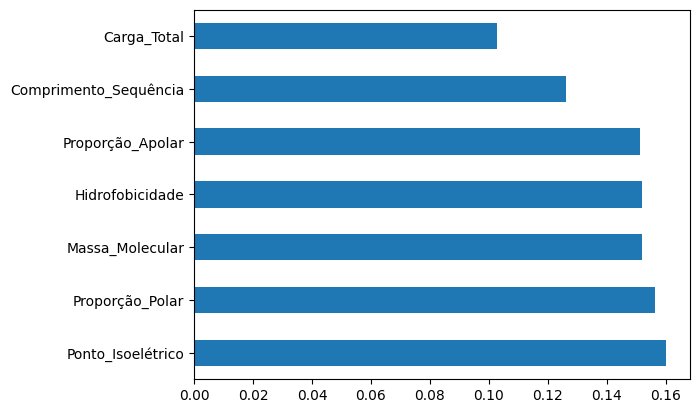

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

X = train.drop(columns=['ID_Proteína', 'Sequência', 'Classe'])
y = LabelEncoder().fit_transform(train['Classe'])

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances)
importances.plot(kind='barh')


In [71]:
# ========== 2. Reduksi Multikolinearitas ==========
# Kami menghapus fitur dengan korelasi ≈ 1 atau VIF tinggi:
# - 'Comprimento_Sequência' sangat berkorelasi dengan 'Massa_Molecular'
# - 'Proporção_Apolar' sangat berkorelasi dengan 'Hidrofobicidade'
columns_to_drop = [col for col in ["Comprimento_Sequência", "Proporção_Apolar"] if col in train.columns]
train_reduced = train.drop(columns=columns_to_drop)
train_reduced.to_csv("../Data/proteinas_train_reduced.csv", index=False)

# ========== 3. Encoding Target ==========
# Mengubah label string 'Classe' menjadi label numerik 'Classe_Label' untuk keperluan machine learning
label_encoder = LabelEncoder()
train_reduced["Classe_Label"] = label_encoder.fit_transform(train_reduced["Classe"])
train_encoded = train_reduced.copy()
train_encoded.to_csv("../Data/proteinas_train_encoded.csv", index=False)

# ========== 3.1 Mapping Biologis ==========
# Menyimpan mapping label biologis berdasarkan pemahaman fungsi protein
mapping_biologis = pd.DataFrame({
    "Label_Asli": label_encoder.classes_,
    "Label_Numerik": range(len(label_encoder.classes_)),
    "Makna_Biologis": [
        "Mempercepat reaksi kimia (Enzim)",
        "Menyusun struktur dan jaringan sel (Struktural)",
        "Fungsi lainnya seperti hormon, antibodi, dll (Outras)",
        "Menerima dan merespons sinyal (Receptora)",
        "Mengangkut zat/molekul (Transporte)"
    ]
})
mapping_biologis.to_csv("../Data/classe_mapping_biologis.csv", index=False)

# ========== 4. Scaling Fitur Numerik ==========
# Melakukan standardisasi agar mean = 0 dan std = 1
# Penting untuk algoritma berbasis jarak dan gradien seperti SVM, KNN, XGBoost
scaler = StandardScaler()
numerical_features = ['Massa_Molecular', 'Ponto_Isoelétrico', 'Hidrofobicidade', 'Carga_Total', 'Proporção_Polar']
train_encoded[numerical_features] = scaler.fit_transform(train_encoded[numerical_features])
train_scaled = train_encoded.copy()
train_scaled.to_csv("../Data/proteinas_train_scaled.csv", index=False)

# ========== 5. Ekstraksi Fitur Sekuensial ==========
# Menghitung proporsi masing-masing asam amino dari kolom 'Sequência'
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
def extract_aa_proportions(seq):
    counts = Counter(seq)
    total = sum(counts.values())
    return {aa: counts.get(aa, 0) / total for aa in amino_acids}

aa_features = train_scaled["Sequência"].apply(extract_aa_proportions)
aa_df = pd.DataFrame(aa_features.tolist())
train_sequencial = pd.concat([train_scaled, aa_df], axis=1)
train_sequencial.to_csv("../Data/proteinas_train_sequencial.csv", index=False)

print("✅ Semua tahap preprocessing, mapping biologis, dan ekstraksi fitur sekuensial berhasil disimpan ke folder '../Data'.")

✅ Semua tahap preprocessing, mapping biologis, dan ekstraksi fitur sekuensial berhasil disimpan ke folder '../Data'.


📊 Random Forest Classification Report
              precision    recall  f1-score   support

      Enzima       0.17      0.18      0.17       647
  Estrutural       0.19      0.21      0.20       646
      Outras       0.18      0.19      0.18       637
   Receptora       0.20      0.16      0.18       625
  Transporte       0.19      0.19      0.19       645

    accuracy                           0.18      3200
   macro avg       0.19      0.18      0.18      3200
weighted avg       0.19      0.18      0.18      3200

🎯 Accuracy Random Forest: 0.1846875


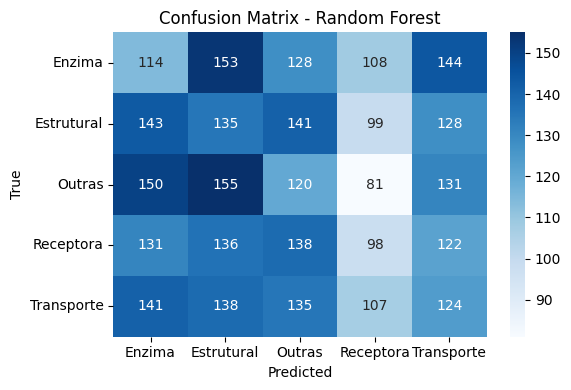

d:\protein-classification-project\kds\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:11:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 XGBoost Classification Report
              precision    recall  f1-score   support

      Enzima       0.19      0.18      0.19       647
  Estrutural       0.20      0.24      0.22       646
      Outras       0.20      0.20      0.20       637
   Receptora       0.21      0.18      0.20       625
  Transporte       0.20      0.21      0.21       645

    accuracy                           0.20      3200
   macro avg       0.20      0.20      0.20      3200
weighted avg       0.20      0.20      0.20      3200

🎯 Accuracy XGBoost: 0.20125


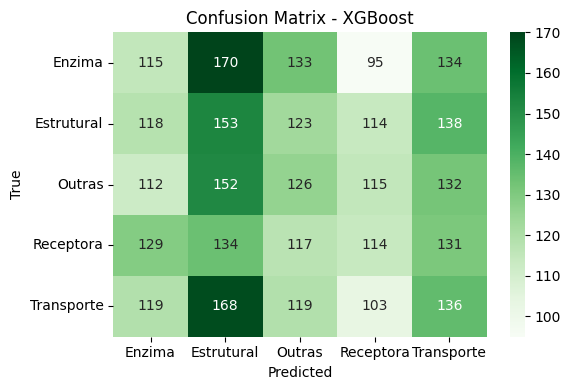

✅ Semua hasil prediksi dan visualisasi berhasil disimpan ke folder outputs.


In [75]:
# ==================== 1. Load dataset hasil preprocessing ====================
data = pd.read_csv("D:/protein-classification-project/Data/proteinas_train_sequencial.csv")

# ==================== 2. Load atau definisikan ulang Label Encoder ====================
label_encoder = LabelEncoder()
data["Classe_Label"] = label_encoder.fit_transform(data["Classe"])  # aman untuk memastikan
classes = label_encoder.classes_

# ==================== 3. Pisahkan fitur dan label ====================
X = data.drop(columns=["ID_Proteína", "Sequência", "Classe", "Classe_Label"])
y = data["Classe_Label"]

# ==================== 4. Split data untuk evaluasi awal ====================
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Pastikan direktori output ada
output_dir = "D:/protein-classification-project/outputs"
os.makedirs(output_dir, exist_ok=True)

# ==================== 5. MODEL 1: RANDOM FOREST ====================
rf_model = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)

print("📊 Random Forest Classification Report")
print(classification_report(y_val, y_pred_rf, target_names=classes))
print("🎯 Accuracy Random Forest:", accuracy_score(y_val, y_pred_rf))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_val, y_pred_rf), annot=True, fmt='d', cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix_rf.png")
plt.show()

# ==================== 6. MODEL 2: XGBOOST ====================
xgb_model = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1,
                          objective='multi:softmax', num_class=5,
                          use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_val)

print("📊 XGBoost Classification Report")
print(classification_report(y_val, y_pred_xgb, target_names=classes))
print("🎯 Accuracy XGBoost:", accuracy_score(y_val, y_pred_xgb))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_val, y_pred_xgb), annot=True, fmt='d', cmap="Greens",
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix_xgb.png")
plt.show()

# ==================== 7. Simpan hasil prediksi untuk analisis biologis ====================
results_rf = pd.DataFrame({
    "ID_Proteína": data.loc[y_val.index, "ID_Proteína"].values,
    "True_Class": label_encoder.inverse_transform(y_val),
    "Pred_RF": label_encoder.inverse_transform(y_pred_rf)
})
results_rf.to_csv(f"{output_dir}/prediction_result_rf.csv", index=False)

results_xgb = pd.DataFrame({
    "ID_Proteína": data.loc[y_val.index, "ID_Proteína"].values,
    "True_Class": label_encoder.inverse_transform(y_val),
    "Pred_XGB": label_encoder.inverse_transform(y_pred_xgb)
})
results_xgb.to_csv(f"{output_dir}/prediction_result_xgb.csv", index=False)

print("✅ Semua hasil prediksi dan visualisasi berhasil disimpan ke folder outputs.")